In [1]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline   
import matplotlib as mpl # Jupyter 노트북에서 그래프를 인라인으로 표시
mpl.rcParams['axes.grid'] = False       # 그래프의 그리드 비활성화
mpl.rcParams['figure.figsize'] = (12,12) # 기본 그래프 크기 설정

from sklearn.model_selection import train_test_split  # 데이터 분할을 위한 함수
from sklearn.metrics import confusion_matrix          # 혼동 행렬 계산을 위한 함수
import matplotlib.image as mpimg        # 이미지 로딩을 위한 라이브러리
import pandas as pd                    # 데이터 프레임 조작을 위한 라이브러리
from PIL import Image                 # 이미지 처리 라이브러리
from IPython.display import clear_output   # 출력 클리어를 위한 함수

import tensorflow as tf                 # TensorFlow 라이브러리
import tensorflow_addons as tfa         # TensorFlow 추가 기능
print(tf.__version__)                     # TensorFlow 버전 출력

from tensorflow.keras import layers    # Keras 레이어 모듈
from tensorflow.keras import losses     # 손실 함수 모듈
from tensorflow.keras import models    # Keras 모델 모듈

2.6.0


In [2]:
# 데이터 준비 - 용종 내시경 데이터셋
# 다운로드한 데이터셋을 학습용과 테스트용으로 분리
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')  # 데이터셋 경로 설정

img_dir = os.path.join(DATASET_PATH, "train")            # 이미지 디렉토리 경로
label_dir = os.path.join(DATASET_PATH, "train_labels")   # 라벨 디렉토리 경로

In [3]:
# 이미지와 라벨 파일 경로 리스트 생성
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()  # 파일명을 정렬
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()  # 파일명을 정렬

In [4]:
# 학습 데이터와 테스트 데이터 분리
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)  # 20%를 테스트용으로 분리

In [5]:
# 학습 및 테스트 예제 수 계산
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

# 결과 출력
print("Number of training examples: {}".format(num_train_examples))  # 학습 예제 수 출력
print("Number of test examples: {}".format(num_test_examples))  # 테스트 예제 수 출력

Number of training examples: 240
Number of test examples: 60


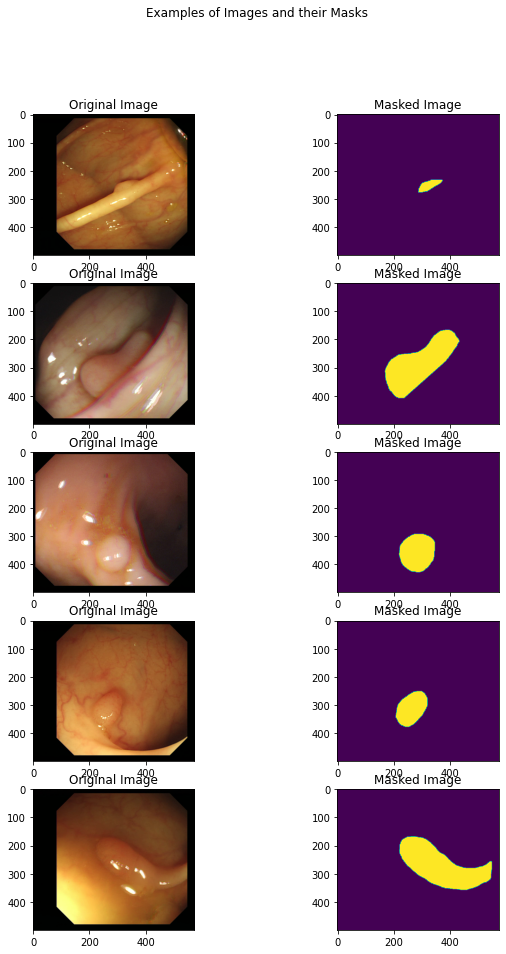

In [6]:
# 랜덤으로 선택할 이미지 수 설정
display_num = 5
r_choices = np.random.choice(num_train_examples, display_num)  # 랜덤으로 학습 데이터에서 선택

# 선택된 이미지와 라벨을 시각화
plt.figure(figsize=(10, 15))  # 그래프 크기 설정
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]  # 랜덤으로 선택된 인덱스
    x_pathname = x_train_filenames[img_num]  # 이미지 경로
    y_pathname = y_train_filenames[img_num]  # 라벨 경로

    plt.subplot(display_num, 2, i + 1)  # 서브플롯 설정 (원본 이미지)
    plt.imshow(Image.open(x_pathname))  # 이미지를 열고 표시
    plt.title("Original Image")  # 제목 설정

    example_labels = Image.open(y_pathname)  # 라벨 이미지 열기
    label_vals = np.unique(example_labels)  # 라벨의 고유 값 추출 (예: 클래스)

    plt.subplot(display_num, 2, i + 2)  # 서브플롯 설정 (마스크 이미지)
    plt.imshow(example_labels)  # 마스크 이미지를 표시
    plt.title("Masked Image")  # 제목 설정

plt.suptitle("Examples of Images and their Masks")  # 전체 제목 설정
plt.show()  # 그래프 표시

In [7]:
# 하이퍼파라미터 설정
image_size = 256  # 이미지 크기 설정 (256x256)
img_shape = (image_size, image_size, 3)  # 이미지 형태 (높이, 너비, 채널)
batch_size = 8  # 배치 크기 설정
max_epochs = 10  # 최대 에포크 수 설정

In [8]:
# tf.data를 활용한 입력 파이프라인 설계
# tf.data.Dataset을 이용해 데이터셋 구축 및 배치 처리와 데이터 증강을 구현할 것입니다.

# 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽어서 처리합니다.
# 레이블은 각 픽셀이 용종 데이터로 주석이 달린 이미지입니다.

def _process_pathnames(fname, label_path):
    # 파일 경로에서 이미지를 읽어서 전처리하는 함수
    img_str = tf.io.read_file(fname)  # 이미지 파일 읽기
    img = tf.image.decode_bmp(img_str, channels=3)  # BMP 형식으로 디코딩

    label_img_str = tf.io.read_file(label_path)  # 라벨 파일 읽기
    label_img = tf.image.decode_bmp(label_img_str, channels=3)  # BMP 형식으로 디코딩
    label_img = tf.image.rgb_to_grayscale(label_img)  # 라벨 이미지를 그레이스케일로 변환

    resize = [image_size, image_size]  # 리사이즈 크기 설정
    img = tf.image.resize(img, resize)  # 이미지 리사이즈
    label_img = tf.image.resize(label_img, resize)  # 라벨 이미지 리사이즈

    scale = 1 / 255.  # 스케일 조정
    img = tf.cast(img, dtype=tf.float32) * scale  # 이미지 정규화
    label_img = tf.cast(label_img, dtype=tf.float32) * scale  # 라벨 정규화

    return img, label_img  # 전처리된 이미지를 반환

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """ 이미지의 수평 또는 수직 이동을 수행하는 함수 """
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])  # 수평 이동 범위 설정
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])  # 수직 이동 범위 설정
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])  # 이미지 이동
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])  # 라벨 이동
    return output_img, label_img  # 이동된 이미지를 반환

In [10]:
def flip_img(horizontal_flip, tr_img, label_img):
    """ 이미지를 랜덤으로 좌우 반전하는 함수 """
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)  # 반전 확률 생성
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),  # 확률에 따라 반전
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img  # 반전된 이미지를 반환

In [11]:
def _augment(img,
             label_img,
             resize=None,  # 이미지를 특정 크기로 리사이즈
             scale=1,  # 이미지 스케일 (예: 1 / 255.)
             hue_delta=0.,  # RGB 이미지의 색조를 랜덤 팩터로 조정
             horizontal_flip=True,  # 랜덤 좌우 반전
             width_shift_range=0.05,  # 이미지를 수평으로 랜덤 이동
             height_shift_range=0.05):  # 이미지를 수직으로 랜덤 이동
    if resize is not None:
        # 두 이미지를 리사이즈
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)  # 색조 조정

    img, label_img = flip_img(horizontal_flip, img, label_img)  # 이미지 반전
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)  # 이미지 이동
    label_img = tf.cast(label_img, dtype=tf.float32) * scale  # 라벨 정규화
    img = tf.cast(img, dtype=tf.float32) * scale  # 이미지 정규화
    return img, label_img  # 증강된 이미지를 반환

In [12]:
#tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),  # 기본 증강 함수 설정
                         threads=4,  # 사용할 스레드 수
                         batch_size=batch_size,  # 배치 크기
                         is_train=True):  # 학습 데이터 여부
    num_x = len(filenames)  # 파일의 수
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))  # 데이터셋 생성
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)  # 전처리 함수 적용

    if is_train:  # 학습할 때만 증강 적용
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)  # 증강 함수 적용
        dataset = dataset.shuffle(num_x * 10)  # 데이터 섞기

    dataset = dataset.batch(batch_size)  # 배치 처리
    return dataset  # 최종 데이터셋 반환

In [13]:
# 학습 데이터셋 생성
train_dataset = get_baseline_dataset(x_train_filenames,  # 학습 이미지 파일 경로
                                     y_train_filenames)  # 학습 라벨 파일 경로
train_dataset = train_dataset.repeat()  # 데이터셋 반복

# 테스트 데이터셋 생성 (증강 없이)
test_dataset = get_baseline_dataset(x_test_filenames,  # 테스트 이미지 파일 경로
                                    y_test_filenames,  # 테스트 라벨 파일 경로
                                    is_train=False)  # 학습 데이터 아님

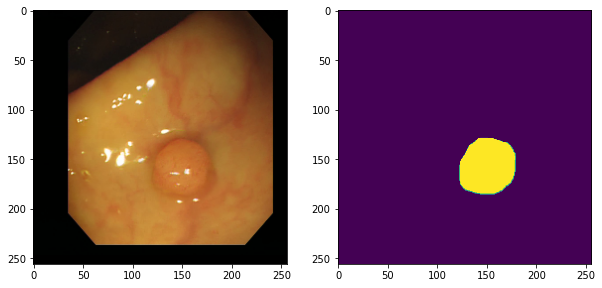

In [14]:
# 데이터셋에서 하나의 배치 가져오기
for images, labels in train_dataset.take(1):  # 첫 번째 배치 가져오기
    plt.figure(figsize=(10, 10))  # 그래프 크기 설정
    img = images[0]  # 첫 번째 이미지 선택

    plt.subplot(1, 2, 1)  # 첫 번째 서브플롯
    plt.imshow(img)  # 이미지 표시

    plt.subplot(1, 2, 2)  # 두 번째 서브플롯
    plt.imshow(labels[0, :, :, 0])  # 라벨 이미지 표시
    plt.show()  # 그래프 표시

In [15]:
# inputs: [batch_size, 256, 256, 3]
# tf.keras.Sequential()을 사용하여 Encoder를 구성합니다.
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool 조합으로 Encoder 구축
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))  # 1st Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))  # 2nd Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation

# conv1 출력 확인: [batch_size, 128, 128, 64]
encoder.add(layers.Conv2D(128, (3, 3), padding='same'))  # 3rd Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))  # 4th Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation # conv2: [batch_size, 64, 64, 128]

# conv2 출력 확인: [batch_size, 64, 64, 128]
encoder.add(layers.Conv2D(256, (3, 3), padding='same'))  # 5th Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))  # 6th Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

# conv3 출력 확인: [batch_size, 32, 32, 256]
encoder.add(layers.Conv2D(512, (3, 3), padding='same'))  # 7th Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))  # 8th Conv Layer
encoder.add(layers.BatchNormalization())  # Batch Normalization
encoder.add(layers.Activation('relu'))  # ReLU Activation

# conv4 출력 확인: [batch_size, 16, 16, 512]

In [16]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))  # 랜덤 입력 데이터 생성
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

(8, 16, 16, 512)


In [17]:
# Decoder
# Encoder의 mirror 형태로 Decoder를 구성합니다.
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation으로 Decoder 구축
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))  # 1st Transpose Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation

# conv_transpose1 출력 확인: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))  # 2nd Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))  # 3rd Transpose Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation
# conv_transpose2 출력 확인: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))  # 4th Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))  # 5th Transpose Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation
# conv_transpose3 출력 확인: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))  # 6th Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))  # 7th Transpose Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation
# conv transpose4 출력 확인: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))  # 8th Conv Layer
decoder.add(layers.BatchNormalization())  # Batch Normalization
decoder.add(layers.Activation('relu'))  # ReLU Activation

# 최종 출력층
decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))  # 출력 레이어

In [18]:
# decoder가 제대로 만들어졌는지 확인
predictions = decoder(bottleneck)  # bottleneck을 decoder에 통과
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 256, 256, 1)


In [19]:
# Encoder와 Decoder를 연결하여 전체 모델 구성
ed_model = tf.keras.Sequential()
ed_model.add(encoder)  # Encoder 추가
ed_model.add(decoder)  # Decoder 추가

In [20]:
# U-Net 구현
# U-Net은 Encoder-Decoder 구조와는 달리, 각 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다.
# Sequential 구조가 아닌 네트워크를 만들 때 사용할 수 있는 API는 tf.keras functional API입니다.
# 여기서는 Model subclassing 방식을 사용하여 tf.keras.Model 클래스를 상속하여 구현할 것입니다.

class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')  # Convolution Layer
        self.bn = layers.BatchNormalization()  # Batch Normalization Layer

    def call(self, inputs, training=True):
        x = self.conv(inputs)  # Convolution 적용
        x = self.bn(x, training=training)  # Batch Normalization 적용
        x = layers.ReLU()(x)  # ReLU Activation 적용
        return x  # 결과 반환

In [21]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)  # 첫 번째 Convolution Block
        self.conv2 = Conv(num_filters * 2, 3)  # 두 번째 Convolution Block

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)  # 첫 번째 Convolution Block 통과
        encoder = self.conv2(encoder, training=training)  # 두 번째 Convolution Block 통과
        return encoder  # 결과 반환

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)  # 첫 번째 Convolution Block (복원)
        self.conv2 = Conv(num_filters, 3)  # 두 번째 Convolution Block (복원)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)  # 첫 번째 Convolution Block 통과
        decoder = self.conv2(decoder, training=training)  # 두 번째 Convolution Block 통과
        return decoder  # 결과 반환

class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)  # Convolution Block
        self.encoder_pool = layers.MaxPool2D()  # Max Pooling Layer

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)  # Convolution Block 통과
        encoder_pool = self.encoder_pool(encoder)  # Max Pooling 적용
        return encoder_pool, encoder  # Pooling된 결과와 Encoder 결과 반환

class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')  # Transpose Convolution Layer
        self.bn = layers.BatchNormalization()  # Batch Normalization Layer
        self.conv_block_r = ConvBlock_R(num_filters)  # 복원용 Convolution Block

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)  # Transpose Convolution 적용
        decoder = self.bn(decoder, training=training)  # Batch Normalization 적용
        decoder = layers.ReLU()(decoder)  # ReLU Activation 적용
        decoder = tf.concat([decoder, concat_tensor], axis=-1)  # Encoder의 결과와 concatenate
        decoder = self.conv_block_r(decoder, training=training)  # 복원용 Convolution Block 통과
        return decoder  # 결과 반환

In [22]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)  # 첫 번째 Encoder Block
        self.encoder_block2 = EncoderBlock(128)  # 두 번째 Encoder Block
        self.encoder_block3 = EncoderBlock(256)  # 세 번째 Encoder Block
        self.encoder_block4 = EncoderBlock(512)  # 네 번째 Encoder Block

        self.center = ConvBlock(1024)  # Center Block

        self.decoder_block4 = DecoderBlock(512)  # 첫 번째 Decoder Block
        self.decoder_block3 = DecoderBlock(256)  # 두 번째 Decoder Block
        self.decoder_block2 = DecoderBlock(128)  # 세 번째 Decoder Block
        self.decoder_block1 = DecoderBlock(64)  # 네 번째 Decoder Block

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')  # 최종 출력 레이어

    def call(self, inputs, training=True):
        # Encoder 단계
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)  # Center Block 통과

        # Decoder 단계
        decoder4 = self.decoder_block4(center, encoder4)  # 첫 번째 Decoder Block 통과
        decoder3 = self.decoder_block3(decoder4, encoder3)  # 두 번째 Decoder Block 통과
        decoder2 = self.decoder_block2(decoder3, encoder2)  # 세 번째 Decoder Block 통과
        decoder1 = self.decoder_block1(decoder2, encoder1)  # 네 번째 Decoder Block 통과

        outputs = self.output_conv(decoder1)  # 최종 출력 생성

        return outputs  # 결과 반환


In [23]:
# U-Net 모델 인스턴스 생성
unet_model = UNet()

In [24]:
# Dice coefficient를 계산하는 함수
def dice_coeff(y_true, y_pred):
    smooth = 1e-10  # 안정성을 위한 작은 값
    # Flatten: 텐서를 1차원으로 변환
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # 예측과 실제 값의 교집합 계산
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)  # Dice coefficient 계산

    return score  # Dice coefficient 반환

In [25]:
# Dice Loss를 계산하는 함수
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)  # Dice Loss는 1 - Dice coefficient
    return loss  # Dice Loss 반환

In [26]:
# Binary crossentropy와 Dice Loss를 결합한 새로운 Loss 함수
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
           dice_loss(y_true, y_pred)  # 두 Loss를 더함
    return loss  # 결합된 Loss 반환

In [27]:
# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam()  # 기본 Learning rate 사용

In [28]:
# 사용할 모델 선택
print('select the Encoder-Decoder model')
model = ed_model
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/ed_model')

#print('select the U-Net model')
#model = unet_model  # U-Net 모델 선택
#checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')  # 체크포인트 디렉토리 설정

select the Encoder-Decoder model


In [29]:
# 모델 컴파일: 옵티마이저, Loss 함수 및 평가 지표 설정
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

# 랜덤 입력 데이터로 예측 수행
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)  # 예측 결과의 shape 출력

(8, 256, 256, 1)


In [30]:
# 모델 요약 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (8, 16, 16, 512)          4693056   
_________________________________________________________________
decoder (Sequential)         (8, 256, 256, 1)          2354913   
Total params: 7,047,969
Trainable params: 7,042,209
Non-trainable params: 5,760
_________________________________________________________________


In [31]:
# Callback 설정
# Callback 함수들을 이용하여 학습 중 원하는 동작을 수행
# ModelCheckpoint: 모델 학습 중 특정 feature를 모니터링하고 기준점을 넘으면 모델 파라미터를 저장
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)  # 체크포인트 디렉토리가 없으면 생성

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,  # 가중치만 저장
                                                 monitor='val_loss',  # 모니터링할 값
                                                 mode='auto',  # 자동 모드
                                                 save_best_only=True,  # 최상의 모델만 저장
                                                 verbose=0)  # 출력 여부

In [32]:
# Cosine Decay를 이용한 Learning Rate 조정
cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)  # Learning Rate 조정 함수
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)  # Learning Rate Scheduler

In [33]:
## 이미지 출력 함수 정의
def print_images():
    # 테스트 데이터셋에서 한 배치 가져오기
    for test_images, test_labels in test_dataset.take(1):
        # 모델을 사용하여 예측 수행
        predictions = model(test_images, training=False)

        # 이미지를 시각화
        plt.figure(figsize=(10, 20))  # 그래프 크기 설정
        plt.subplot(1, 3, 1)  # 첫 번째 서브플롯
        plt.imshow(test_images[0, :, :, :])  # 입력 이미지 표시
        plt.title("Input image")  # 제목 설정

        plt.subplot(1, 3, 2)  # 두 번째 서브플롯
        plt.imshow(test_labels[0, :, :, 0])  # 실제 마스크 표시
        plt.title("Actual Mask")  # 제목 설정

        plt.subplot(1, 3, 3)  # 세 번째 서브플롯
        plt.imshow(predictions[0, :, :, 0])  # 예측 마스크 표시
        plt.title("Predicted Mask")  # 제목 설정
        plt.show()  # 그래프 표시

In [34]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 12s 206ms/step - loss: 1.4166 - dice_loss: 0.8132 - val_loss: 1.9991 - val_dice_loss: 0.9067
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 194ms/step - loss: 1.1691 - dice_loss: 0.7828 - val_loss: 1.6107 - val_dice_loss: 0.8743
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 196ms/step - loss: 1.0721 - dice_loss: 0.7505 - val_loss: 1.3362 - val_dice_loss: 0.8271
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 197ms/step - loss: 1.0018 - dice_loss: 0.7117 - val_loss: 1.3148 - val_di

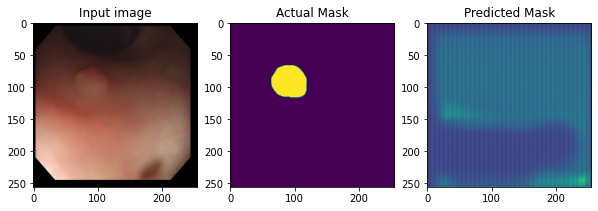

In [35]:
# print sample image after training
print_images()

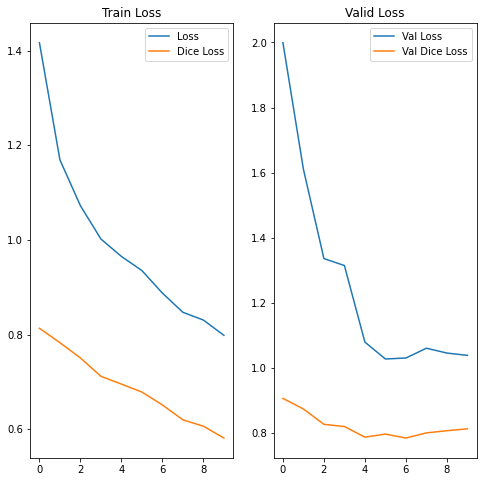

In [36]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [37]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [38]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [39]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.47662901878356934


In [40]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

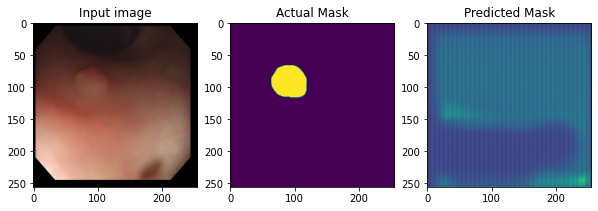

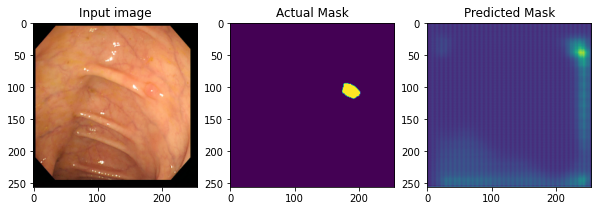

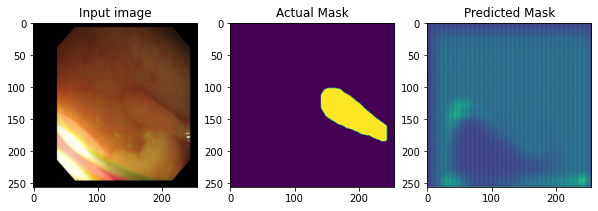

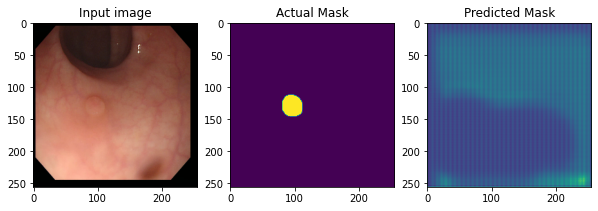

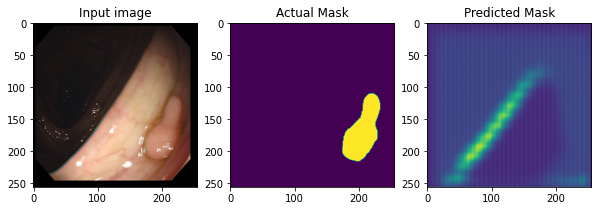

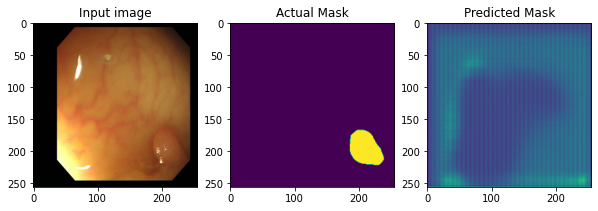

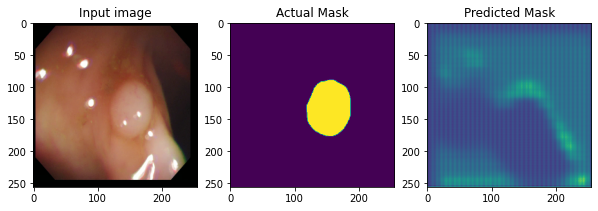

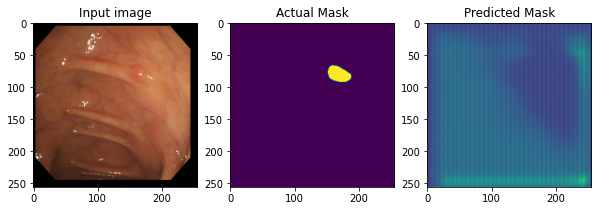

In [41]:
print_images()

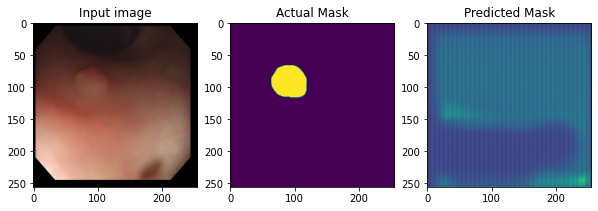

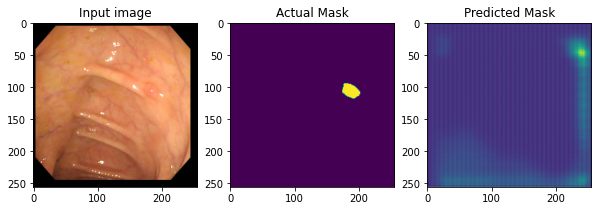

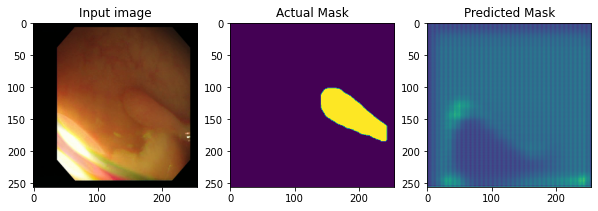

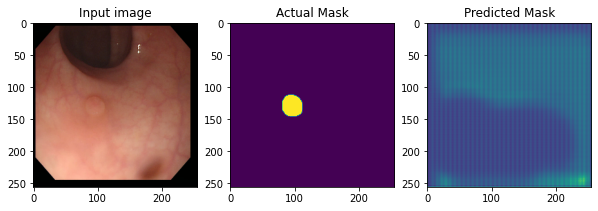

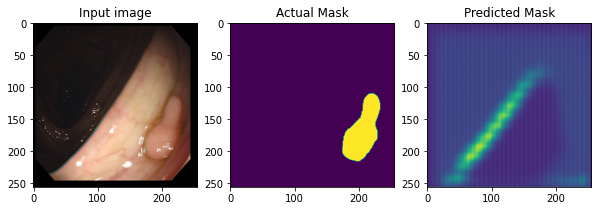

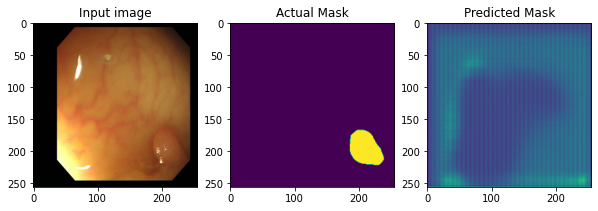

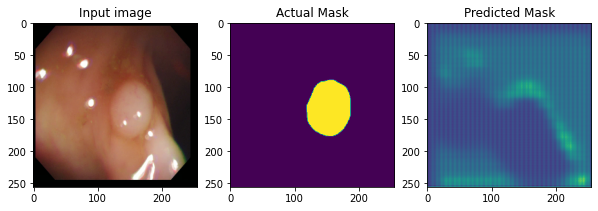

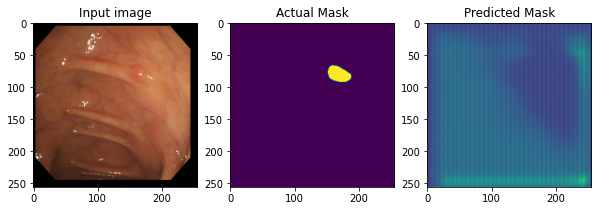

In [42]:
# 학습 후 샘플 이미지 출력
print_images()

In [43]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


In [44]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [45]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

### U-Net Model결과
![U-Net Model](unetmodel.jpg)

### E-D Model결과
![Encorder-Decorder Model](edmodel.jpg)

### U-Net과 Encorder-Decorder Model 비교
![비교표](diff.jpg)

# U-Net과 개선된 Encoder-Decoder 모델 성능 분석

## 1. Mean IoU 비교
- **U-Net Mean IoU**: 0.9439
- **Encoder-Decoder Model Mean IoU**: 0.4766

U-Net은 매우 높은 Mean IoU 수치를 기록하고 있습니다. 이는 모델이 픽셀 단위에서 목표를 잘 분리하고 있음을 의미합니다. 반면, 개선된 Encoder-Decoder 모델의 Mean IoU는 상당히 낮습니다. 이는 모델이 정확하게 예측하지 못하고 있음을 나타내며, 학습이 잘 이루어지지 않았거나 모델 아키텍처에서 문제가 있을 수 있습니다.

## 2. 그래프 분석

### U-Net Loss 그래프:
- **Train Loss**: 훈련 손실이 빠르게 감소하고 있으며, 안정적인 수치를 기록하고 있습니다.
- **Validation Loss**: 검증 손실 또한 감소 추세를 보이고 있으며, 과적합이 발생하지 않고 있습니다.

### Encoder-Decoder Model Loss 그래프:
- **Train Loss**: 훈련 손실이 처음에 감소한 후, 이후에는 불안정하게 변동하고 있습니다. 이는 모델이 데이터에 적합하지 않거나 충분히 학습되지 않았음을 시사합니다.
- **Validation Loss**: 검증 손실이 초기에는 감소하지만, 이후 급격히 증가하고 있습니다. 이는 모델이 학습 데이터에 과적합되는 경향이 있음을 나타냅니다.

## 3. 성능 분석

### U-Net:
- 높은 Mean IoU와 안정적인 손실 감소는 U-Net이 해당 데이터셋에서 효과적으로 작동하고 있음을 보여줍니다. 이는 U-Net의 전형적인 구조가 해당 문제에 적합하다는 것을 의미합니다.

### Encoder-Decoder Model:
- 낮은 Mean IoU와 불안정한 손실 감소는 개선된 모델이 데이터에 적합하지 않거나 학습이 부족했음을 나타냅니다. 이는 다음과 같은 문제에서 기인할 수 있습니다:
  - **모델 아키텍처**: Encoder-Decoder 구조가 U-Net보다 효과적이지 않을 수 있습니다.
  - **하이퍼파라미터**: 학습률, 배치 크기 등 하이퍼파라미터가 부적절할 수 있습니다.
  - **데이터 문제**: 데이터의 품질이나 양이 부족할 수 있습니다.

## 결론
U-Net 모델은 성능이 뛰어나지만, 개선된 Encoder-Decoder 모델은 여러 측면에서 개선이 필요합니다. 모델 아키텍처를 재검토하고, 하이퍼파라미터 조정 및 데이터 전처리 방법을 개선하여 다시 시도하는 것이 좋습니다. 추가적인 실험을 통해 성능을 높일 수 있는 방법을 모색해야 할 것입니다.

---

# 오늘 학습 내용 정리

## 배운 점
- **U-Net과 Encoder-Decoder 모델**의 구조와 작동 원리를 이해하게 되었다.
- **Mean IoU**의 개념과 계산 방법을 배웠으며, 성능 평가에 있어 중요한 지표임을 알게 되었다.
- 손실 함수와 모델의 학습 과정에서의 변화를 분석하는 방법을 익혔다.

## 아쉬운 점
- Encoder-Decoder 모델의 성능이 낮은 이유를 깊이 있게 분석하지 못한 점이 아쉬웠다.
- 실제 데이터에 대한 실험이 부족하여 이론적인 이해에 그친 부분이 있다.

## 느낀 점
- 이미지 분할 모델의 성능 평가가 얼마나 중요한지를 깨달았다. 
- 다양한 모델 아키텍처를 비교 분석하는 과정이 흥미로웠다.

## 어려웠던 점
- 모델 학습 과정에서 하이퍼파라미터 조정의 중요성을 이해하는 데 시간이 걸렸다.
- 그래프 분석과 결과 해석이 다소 복잡하게 느껴졌고, 실질적인 예시가 필요하다.

## Encoder-Decoder 모델 성능 분석 방법

### 1. 모델 아키텍처 검토
- **레이어 구성**: 각 레이어의 수와 종류(예: Convolutional, Pooling 등)를 검토합니다.
- **Skip Connections**: U-Net과 같은 skip connection을 추가해볼 수 있습니다. 이는 정보 손실을 줄이는 데 도움이 됩니다.

### 2. 하이퍼파라미터 조정
- **학습률**: 학습률을 조정하여 모델의 수렴 속도를 개선할 수 있습니다.
- **배치 크기**: 다양한 배치 크기를 시도하여 최적의 설정을 찾습니다.
- **정규화 기법**: Dropout, Batch Normalization 등의 기법을 적용해 볼 수 있습니다.

### 3. 데이터 분석
- **데이터의 품질**: 데이터셋의 레이블이 정확한지 확인합니다.
- **데이터 증강**: 데이터 증강 기법을 사용하여 학습 데이터를 다양화하고 일반화 성능을 개선합니다.
- **클래스 불균형**: 클래스 간 불균형이 있는지 확인하고, 이를 해결하기 위한 방법(예: 오버샘플링, 언더샘플링)을 적용합니다.

### 4. 손실 함수 검토
- **손실 함수 선택**: 문제에 적합한 손실 함수를 선택합니다. 예를 들어, 다중 클래스 분할의 경우 Cross-Entropy Loss를 사용할 수 있습니다.
- **가중치 조정**: 클래스 불균형이 있는 경우, 손실 함수에 클래스 가중치를 추가할 수 있습니다.

### 5. 성능 평가 지표
- **Mean IoU 외의 지표**: Precision, Recall, F1 Score 등 다양한 지표를 사용하여 모델 성능을 평가합니다.
- **시각화**: 예측 결과와 실제 결과를 비교하여 시각적으로 분석합니다. 잘못된 예측 사례를 찾아 원인을 분석합니다.

### 6. 실험 기록 및 비교
- **실험 기록**: 다양한 설정에 대한 성능을 기록하여 어떤 조합이 더 나은 결과를 가져오는지 분석합니다.
- **다른 모델과 비교**: U-Net과 같은 다른 아키텍처와 성능을 비교하여 어떤 요소가 성능에 영향을 미치는지 살펴봅니다.